#  Проект: Анализ рынка EUR/USD и предсказание курса

Имеются данные по торговле на рынке EUR/USD с 4 мая 2003 года по 16 октября 2021 года.

**Цель исследования:**
Необходимо провести анализ рынка и спрогнозировать значение курса EUR/USD в конце торгов в течение следующего 4-часового временного интервала и построить модель для такого предсказания.

**Описание данных:**
Данные лежат в файле `EURUSD_forex_trading.csv`. Для каждой даты набор данных содержит значения открытия/закрытия/максимума/минимума и объема торгов для каждого 4-часового временного интервала (столбцы `open`, `close`, `high`, `low`,  `volume`, соответственно), где
`close` - целевой признак.

Источник данных: https://forex.tradingcharts.com/chart/

**Ход исследования:**
- **Загрузка данных.**
- **Разведочный анализ данных.**
- **Обучение моделей.** Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных. Выберем лучшую модель на основе метрики RMSE.
- **Сравнение метрики RMSE.**
- **Выводы.**

## Загрузка данных

Выполним загрузку библиотек.

In [1]:
#установим библиотеки
!pip install scikit-learn==1.4.0
!pip install shap 
!pip install phik -q
!pip install missingno
!pip install pandas_ta 

import pandas as pd 
import numpy as np
import pandas_ta as ta
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import warnings
warnings.simplefilter('ignore')

#библиотеки для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

#класс для разделения на выборки
from sklearn.model_selection import train_test_split 

#загружаем классы для подготовки данных
from sklearn.preprocessing import MinMaxScaler

#функции для работы с метриками
from sklearn.metrics import make_scorer, root_mean_squared_error
#from sklearn.metrics import confusion_matrix

#импортируем классы GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

#загружаем модели
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR

#функция для анализа временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose

#константа
RANDOM_STATE = 42

Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм.

In [2]:
data = pd.read_csv('/Users/margarita/Desktop/datasets/EURUSD_forex_trading.csv')

## Разведочный анализ данных

Изучим общую информацию о датафрейме.

In [3]:
data.head()

,Gmt time,open,high,low,close,volume
0,04.05.2003 21:00:00.000,1.12354,1.12354,1.12166,1.12274,95533.0976
1,05.05.2003 01:00:00.000,1.12242,1.12276,1.12067,1.12126,93778.5996
2,05.05.2003 05:00:00.000,1.12139,1.12255,1.12030,1.12113,90924.6992
3,05.05.2003 09:00:00.000,1.12092,1.12331,1.12049,1.12174,91254.6992
4,05.05.2003 13:00:00.000,1.12194,1.12900,1.12130,1.12712,308003.4083


In [4]:
data.shape

(28860, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28860 entries, 0 to 28859
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Gmt time  28860 non-null  object 
 1   open      28860 non-null  float64
 2   high      28860 non-null  float64
 3   low       28860 non-null  float64
 4   close     28860 non-null  float64
 5   volume    28860 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.3+ MB


In [6]:
#переименуем столбец
data = data.rename(columns= {'Gmt time': 'time'})

In [7]:
#переведем дату в формат datetime64
data['time'] = pd.to_datetime(data['time'], format='%d.%m.%Y %H:%M:%S.%f')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28860 entries, 0 to 28859
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    28860 non-null  datetime64[ns]
 1   open    28860 non-null  float64       
 2   high    28860 non-null  float64       
 3   low     28860 non-null  float64       
 4   close   28860 non-null  float64       
 5   volume  28860 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.3 MB


In [8]:
#время сделаем индексом
data = data.set_index('time')
data.tail()

,open,high,low,close,volume
time,,,,,
2021-10-15 01:00:00,1.15940,1.16120,1.15938,1.16082,5738.63
2021-10-15 05:00:00,1.16082,1.16189,1.15995,1.16034,13149.66
2021-10-15 09:00:00,1.16033,1.16124,1.15892,1.15923,14914.33
2021-10-15 13:00:00,1.15923,1.16103,1.15893,1.15953,20002.53
2021-10-15 17:00:00,1.15952,1.16060,1.15933,1.16040,5620.05


In [9]:
#проверка на наличие пропусков
data.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [10]:
#проверка хронологичности дат
data.index.is_monotonic_increasing

True

In [11]:
print('В датасете представлена информация за период: с', 
      data.index.min(), 'по', data.index.max())

В датасете представлена информация за период: с 2003-05-04 21:00:00 по 2021-10-15 17:00:00


Рассмотрим график зависимости курса от времени.

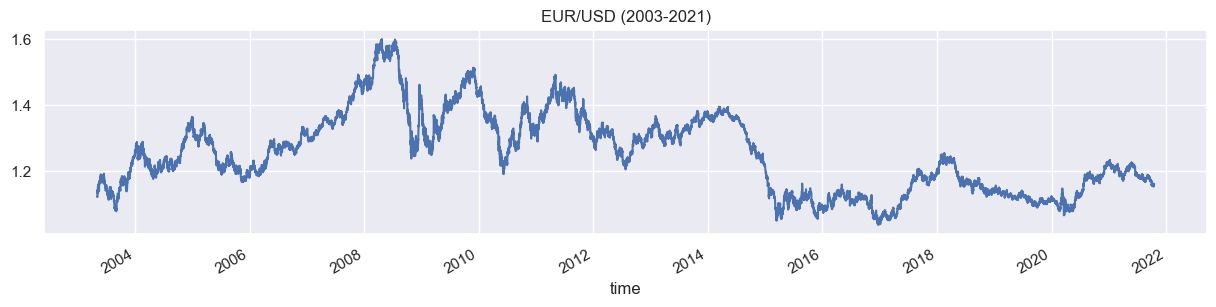

In [12]:
data.close.plot(title='EUR/USD (2003-2021)', figsize=(15,3))
plt.show()

Рассмотрим график для показателя `RSI (Relative strength index, индекс относительной силы)` — индикатора технического анализа, показывающего соотношение положительных и отрицательных изменений цены финансового инструмента, помогающего определить силу тренда и вероятность его смены.

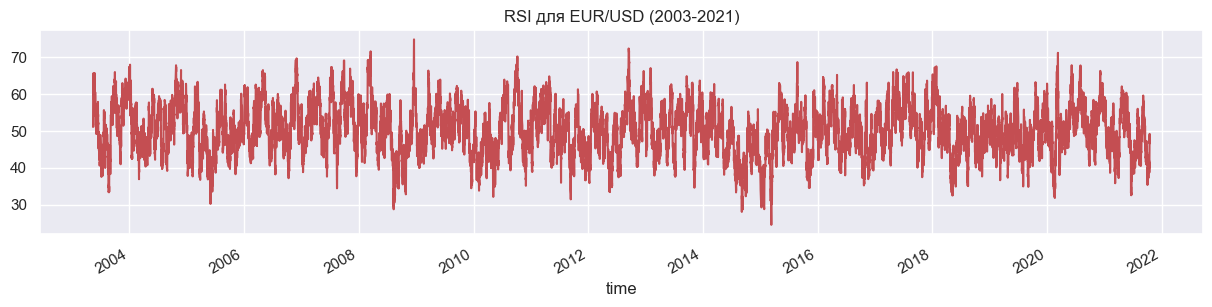

In [13]:
pd.DataFrame(data.close).ta.rsi(length=6*9).plot(title='RSI для EUR/USD (2003-2021)', 
                                                 figsize=(15,3), 
                                                 color=sns.color_palette().as_hex()[3])
plt.show()

Выведем описательные статистики.

In [14]:
#вывод описательных статистик
data.describe()

,open,high,low,close,volume
count,28860.000000,28860.000000,28860.000000,28860.000000,28860.000000
mean,1.254449,1.256497,1.252384,1.254457,83078.835388
std,0.119505,0.119839,0.119131,0.119503,100637.239637
min,1.036930,1.039200,1.034050,1.036970,0.000000
25%,1.154278,1.155988,1.152438,1.154285,20322.189925
50%,1.242230,1.244390,1.239885,1.242260,47812.714850
75%,1.338760,1.340750,1.336512,1.338763,102454.949700
max,1.599500,1.604030,1.596950,1.599240,752269.093800


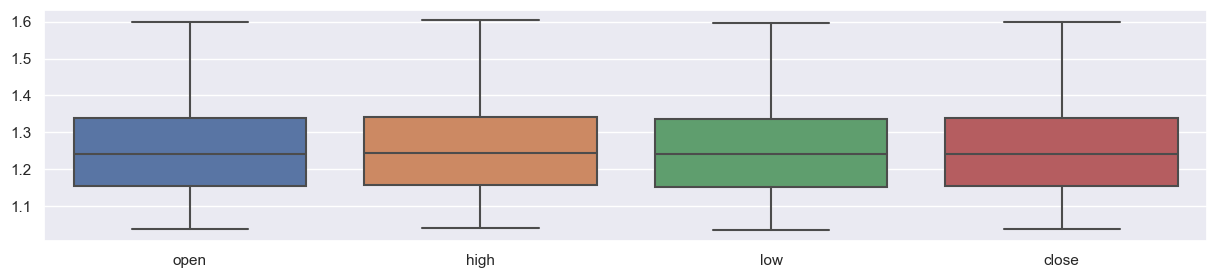

In [15]:
#боксплоты для признаков open, high, low, close
plt.figure(figsize=(15,3))
sns.boxplot(data.drop('volume', axis=1))
plt.show()

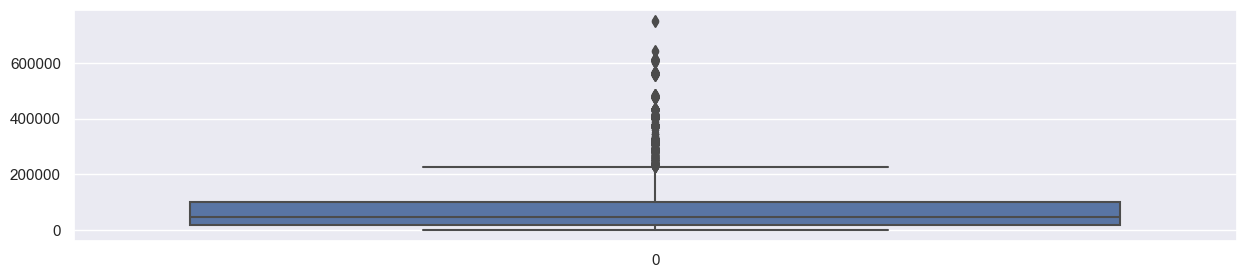

In [16]:
#боксплот для признака volume
plt.figure(figsize=(15,3))
sns.boxplot(data.volume)
plt.show()

Построим графики скользящего среднего и стандартного отклонения.
Скользящее среднее сглаживает исходный временной ряд и помогает выявить тенденции. Чем шире окно, тем сглаженнее тенденция. В случае очень шумных данных, как в нашем датафрейме, эта процедура может помочь обнаружить общие закономерности.

In [17]:
#series - данные
#window - размер окна 
#plot_intervals - показать доверительные интервалы
#plot_anomalies - показывать аномалии

def plot_moving_average(series, window, plot_intervals=False, scale=2, 
                        plot_anomalies=False, std=False):
    
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()

    plt.figure(figsize=(15,5))
    plt.title(f'Скользящее среднее по EUR/USD при размере окна = {window}')
    
    plt.plot(series[window:], label='actual values')
    plt.plot(rolling_mean, 'g', label='rolling mean trend') 
    if std: 
        plt.plot(rolling_std, label='rolling std trend')

    #построение доверительных интервалов для сглаженных значений
    if plot_intervals:
        rolling_rmse = root_mean_squared_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (rolling_rmse + scale * deviation)
        upper_bond = rolling_mean + (rolling_rmse + scale * deviation)
        plt.plot(upper_bond, 'r--', label='upper bond / lower bond')
        plt.plot(lower_bond, 'r--')
        
        #найти аномальные значения
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, 'ro', markersize=10)
        
    plt.legend()
    plt.grid(True)

Рассмотрим график скользящего среднего при размере окна = 1000. Общие тенденции из
скользящего стандартного отклонения стали более отчетливы. Скользящее стандартное отклонение колеблется вблизи значения 0.1.

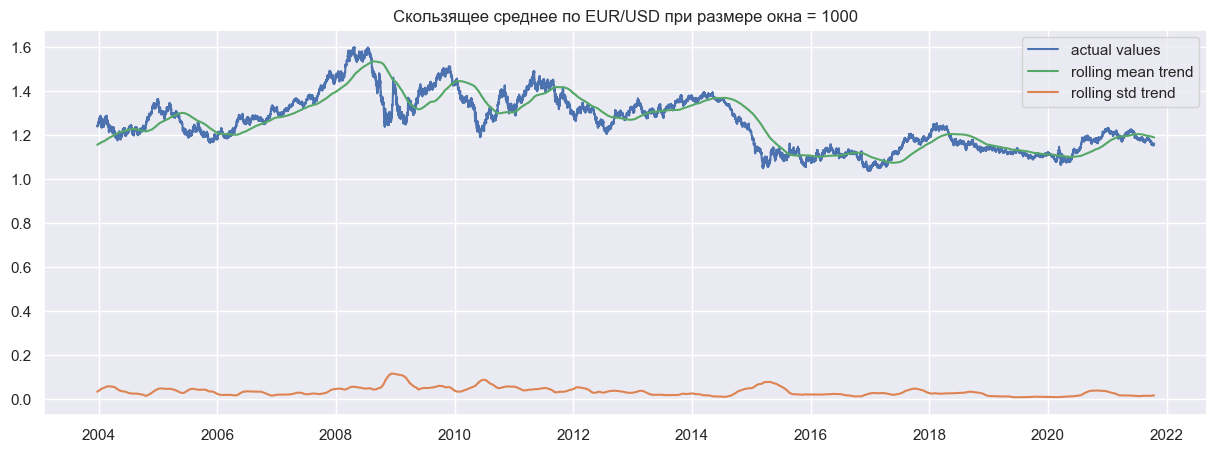

In [18]:
plot_moving_average(data.close, 1000, std=True) 

Рассмотрим аномалии в данных с помощью простого метода и расчета RSME в функции выше.
Ниже на графике можно заметить, что такой подход отмечает аномалиями резкие падения курса.

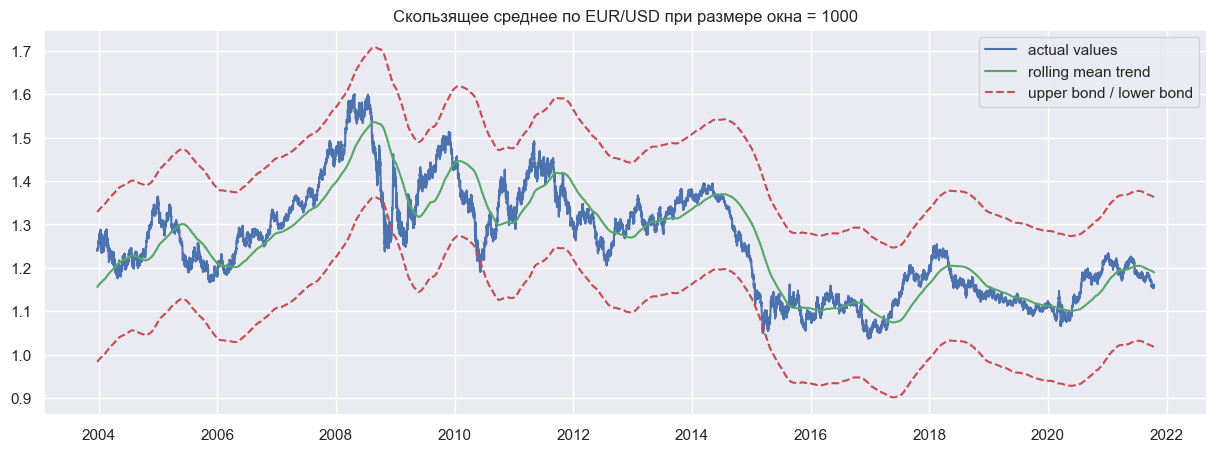

In [19]:
plot_moving_average(data.close, 1000, plot_intervals=True)

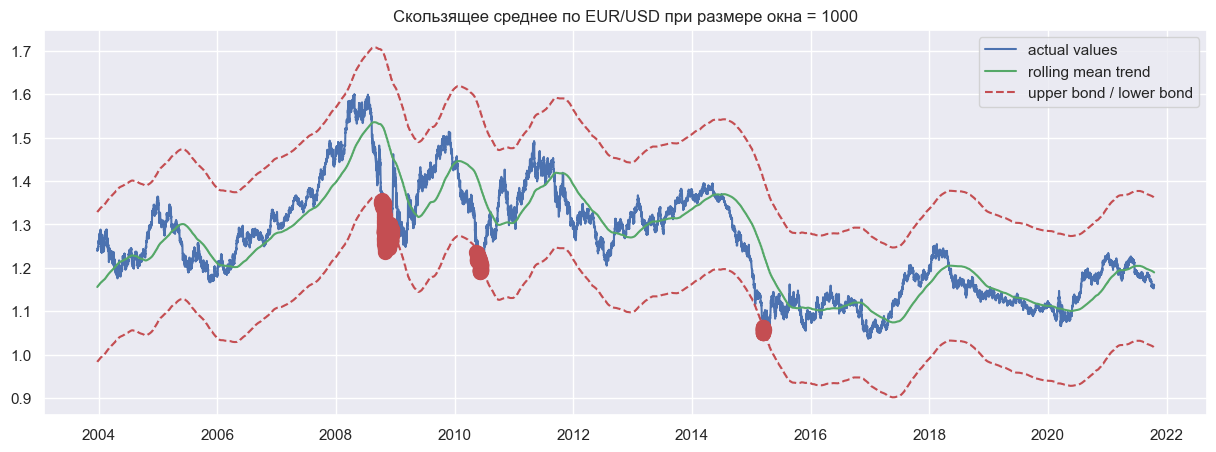

In [20]:
plot_moving_average(pd.DataFrame(data.close), 1000, plot_intervals=True, 
                    plot_anomalies=True)

Выполним проверку временного ряда на стационарность.

In [21]:
#построение графиков временного ряда, его ACF и PACF
#тест Дики-Фуллера
def tsplot(y, lags=None, figsize=(15, 6)):        
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
        
    y.plot(ax=ts_ax)
    
    p_value = sm.tsa.stattools.adfuller(y)[1]
    adf = sm.tsa.stattools.adfuller(y)[0] 
    сritical_values = sm.tsa.stattools.adfuller(y)[4] 
    
    ts_ax.set_title('Графики анализа временного ряда\n Тест Дики-Фуллера: p-value={0:.4f}'.format(p_value))
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    
    print('Критерий ADF: %f' % adf)
    print('p-value: %f' % p_value)
    print('Критические значения:')
    for key, value in сritical_values.items():
        print('\t%s: %.3f' % (key, value))
    
    if adf<сritical_values['5%']: 
        print ('Нулевая гипотеза отвергнута, временной ряд стационарен.')
    else:
        print ('Нулевая гипотеза не отвергнута, временной ряд не стационарен.')

Критерий ADF: -2.204856
p-value: 0.204488
Критические значения:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Нулевая гипотеза не отвергнута, временной ряд не стационарен.


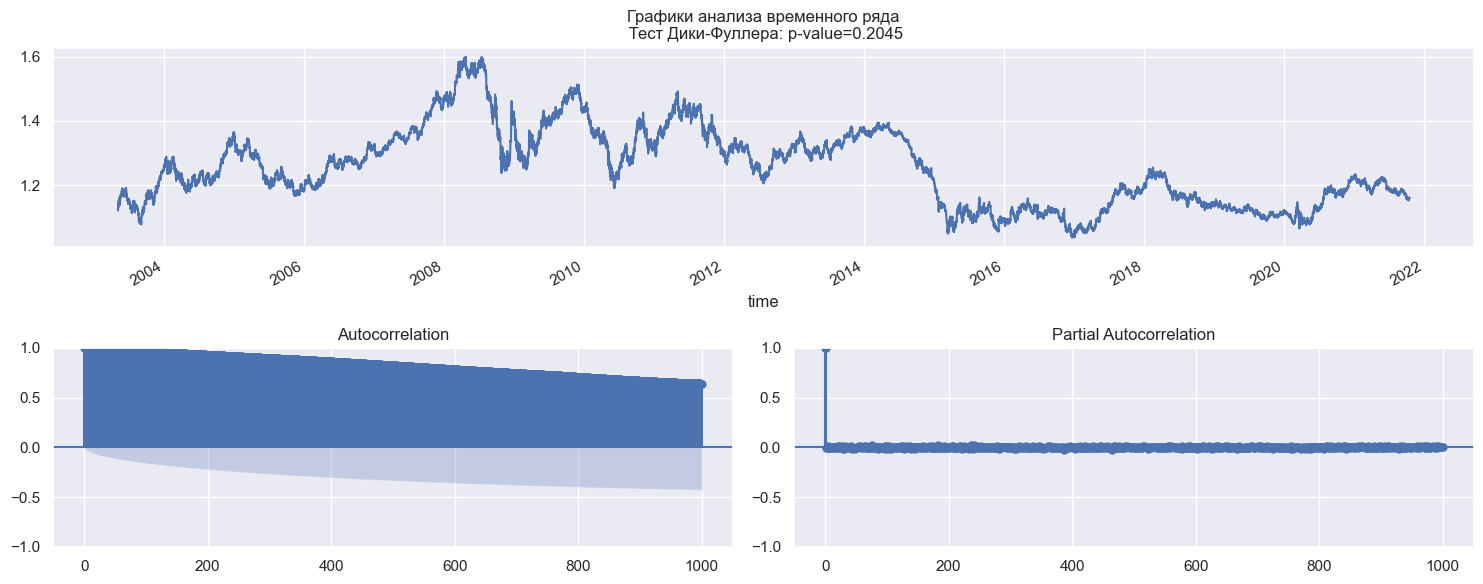

In [22]:
tsplot(data['close'], lags=1000)

Вычислим разности временного ряда. Для них также определим скользящее среднее и скользящее стандартное отклонение.

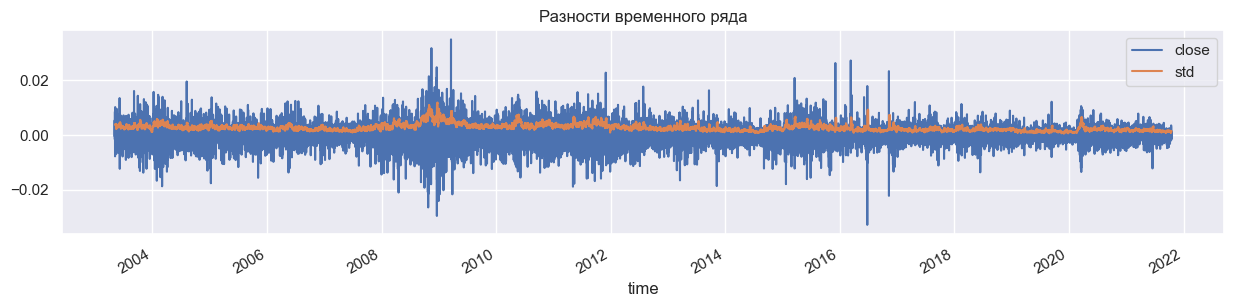

In [23]:
data_shift_mean_std = pd.DataFrame(data['close'] - data['close'].shift(), columns=['close'])
data_shift_mean_std['std'] = data_shift_mean_std['close'].rolling(24).std()
data_shift_mean_std.plot(title='Разности временного ряда', figsize=(15,3))
plt.show()

Используем функцию `seasonal_decomposed`, которая разложит временной ряд на 3 составляющие: тренд, сезонность и остаток. Далее построим графики.

In [24]:
decomposed = seasonal_decompose(data['close'], period = 1000)

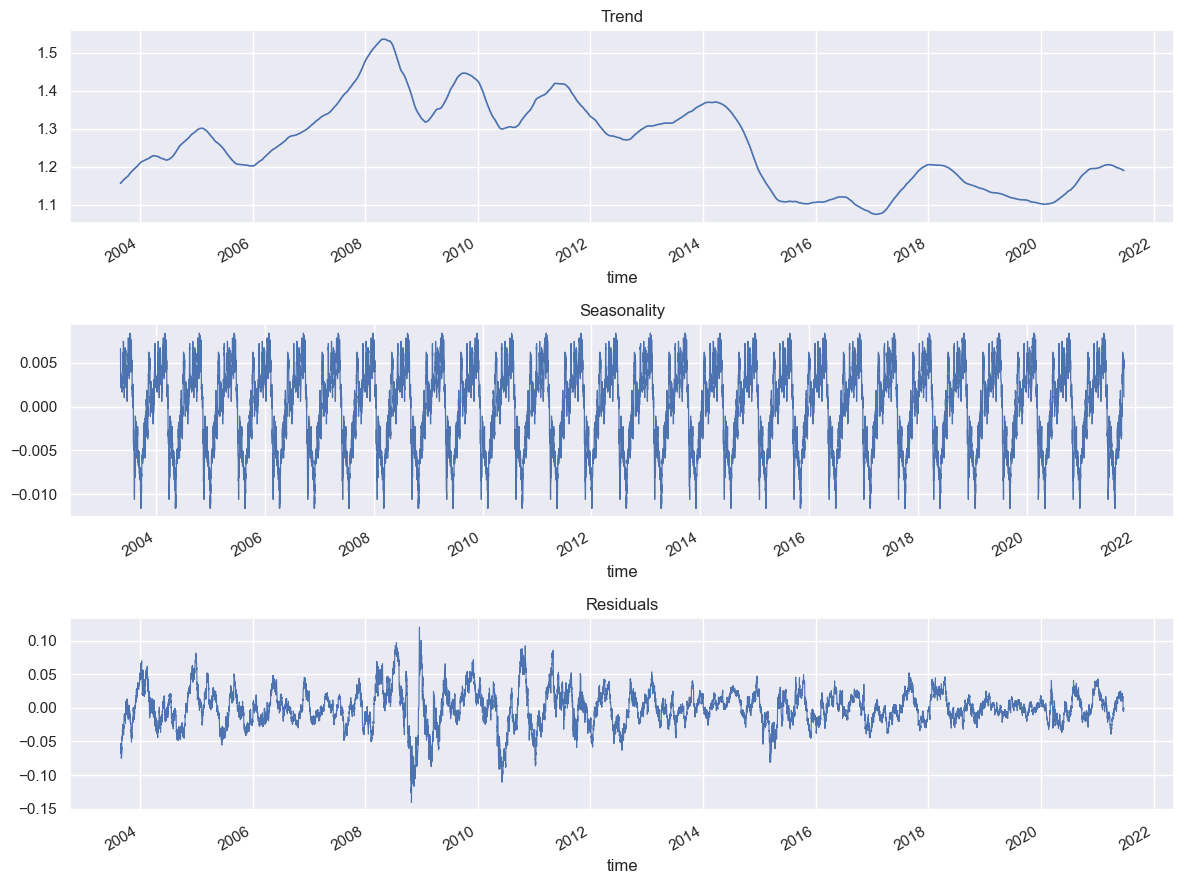

In [25]:
sns.set()

plt.figure(figsize=(12,9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), linewidth=1.2)
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), linewidth=0.9)
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), linewidth=0.8)
plt.title('Residuals')
plt.tight_layout()

Визуализируем сезонность на более коротком интервале.

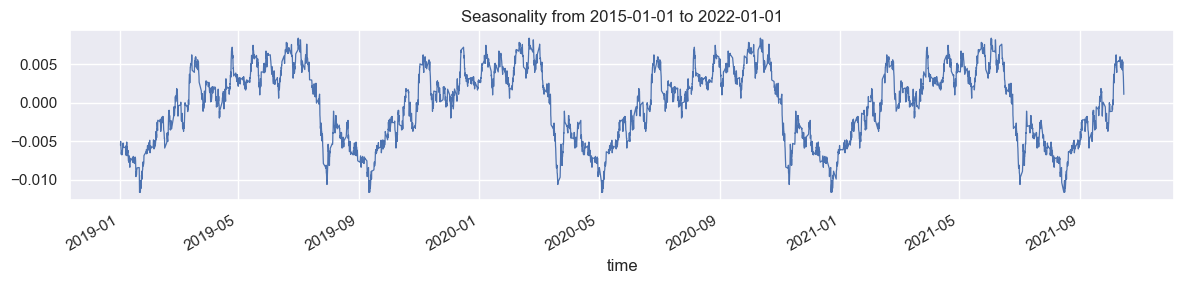

In [26]:
plt.figure(figsize=(12,3))
decomposed.seasonal['2019-01-01':'2022-01-01'].plot(ax=plt.gca(), linewidth=0.9)
plt.title('Seasonality from 2015-01-01 to 2022-01-01')
plt.tight_layout()

**Выводы:**
- Была выполнена загрузка данных курса EUR/USD. В данных содержится 28860 записей о курсе за каждый 4-часовой интервал за период с 2003-05-04 21:00:00 по 2021-10-15 17:00:00. Пропуски в данных отсутствуют.
- Были построены графики зависимости курса от времени и показателя `RSI`, а также боксплоты для значений `open`, `high`, `low`, `close`, `volume`. Средние значения показателей `open`, `high`, `low`, `close` составляют около 1.25, минимумы - около 1.04, максимумы - около 1.60. Среднее значение показателя `volume` составляет 83078.84, минимум - 0, максимум - 752269.09. 
- Были построены графики скользящего среднего и стандартного отклонения. Скользящее среднее сгладило исходный временной ряд и помогло выявить закономерности. С помощью функции `seasonal_decomposed` было выполнено разложение временного ряда на 3 составляющие: тренд, сезонность и остаток. Были построены их графики. Сезонность составляет около 9 месяцев, т.е. колебания в данных повторяются с данной периодичностью. Значение сначала довольно резко уменьшается, а затем постепенно набирает рост. После достижения пика на этом периоде следует спад, а далее снова поъем. Циклические изменения курса, которые повторяются с постоянным интервалом времени, составляют около 0.012. В течение рассмотренного периода происходили резкие падения курса, идентифицированные как аномалии.
- Установлено, что временной ряд является нестационарным, меняются его среднее значение и стандартное отклонение. При этом разности временного ряда более стационарны, чем сам ряд.

## Обучение

In [27]:
data.head()

,open,high,low,close,volume
time,,,,,
2003-05-04 21:00:00,1.12354,1.12354,1.12166,1.12274,95533.0976
2003-05-05 01:00:00,1.12242,1.12276,1.12067,1.12126,93778.5996
2003-05-05 05:00:00,1.12139,1.12255,1.12030,1.12113,90924.6992
2003-05-05 09:00:00,1.12092,1.12331,1.12049,1.12174,91254.6992
2003-05-05 13:00:00,1.12194,1.12900,1.12130,1.12712,308003.4083


С помощью функции выполним добавление новых признаков. Признаки из исходного датасета:
- `close` - значение закрытия
- `open` - значение открытия
- `high_1` - предыдущее значение `high`
- `low_1` - предыдущее значение `high`
- `volume_1` - предыдущее значение `volume`

Новые признаки:
- `RSI (Relative strength index, индекс относительной силы)` — индикатор технического анализа, показывающий соотношение положительных и отрицательных изменений цены финансового инструмента, определяющий силу тренда и вероятность его смены
- `dayofweek`, `hour`, `day`, `month` - данные о времени
- `lag_close_X`- сдвиг значения `close`

In [28]:
def make_features(data, max_lag):
    data_new = data[['open', 'close']]
    data_new['high_1'] = data['high'].shift()
    data_new['low_1'] = data['low'].shift()
    data_new['volume_1'] = data['volume'].shift()
    
    #данные о времени
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    data_new['day'] = data_new.index.day
    data_new['month'] = data_new.index.month
    
    #RSI
    data_new['RSI'] = data_new.ta.rsi(length = 6)
    
    #сдвиг значения
    for lag in range(60, max_lag, 198):
        data_new['lag_close_{}'.format(lag)] = data_new['close'].shift(lag)
    
    data_new = data_new.dropna(axis=0)
    return data_new

Применим функцию к датасету.

In [29]:
data_new = make_features(data, 1051)
data_new.head(3)

,open,close,high_1,low_1,volume_1,dayofweek,hour,day,month,RSI,lag_close_60,lag_close_258,lag_close_456,lag_close_654,lag_close_852,lag_close_1050
time,,,,,,,,,,,,,,,,
2004-01-02 18:00:00,1.25998,1.25832,1.26165,1.25624,407725.1016,4,18,2,1,50.254378,1.23739,1.14933,1.12556,1.13570,1.16883,1.12274
2004-01-04 22:00:00,1.25832,1.26569,1.26031,1.25762,285794.4981,6,22,4,1,72.780498,1.23771,1.14741,1.12409,1.13432,1.16818,1.12126
2004-01-05 02:00:00,1.26602,1.26554,1.26687,1.25795,100452.7012,0,2,5,1,71.984385,1.23893,1.14847,1.12539,1.13544,1.16146,1.12113


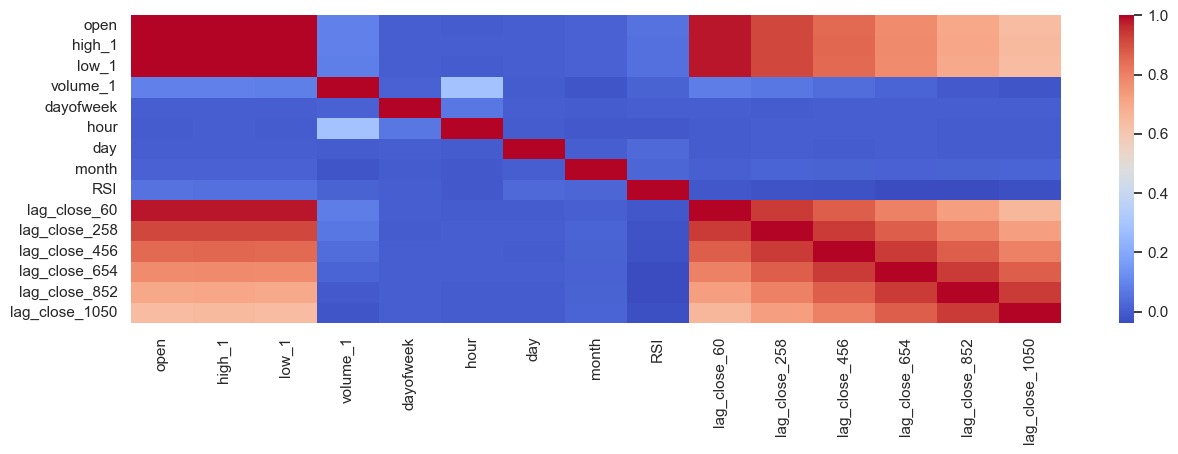

In [30]:
plt.figure(figsize=(15,4))
sns.heatmap(data_new.drop(columns=['close'], axis=1).corr(), cmap='coolwarm')
plt.show()

Разделим данные на обучающую и тестовую выборки. Сделаем тестовую выборку размером 10% от исходных данных. 

In [31]:
train, test = train_test_split(data_new, shuffle=False, test_size=0.1)

X_train = train.drop(columns=['close'], axis=1)
X_test = test.drop(columns=['close'], axis=1)
y_train = train['close']
y_test = test['close']

In [32]:
print('Размер X_train:', X_train.shape)
print('Размер y_train:', y_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер y_test:', y_test.shape)

Размер X_train: (25029, 15)
Размер y_train: (25029,)
Размер X_test: (2781, 15)
Размер y_test: (2781,)


Учтем, что все признаки являются числовыми. Масштабируем их с помощью MinMaxScaler().

In [33]:
#в датасете имеются только количественные признаки
#создадим переменную с экземпляром класса MinMaxScaler
scaler = MinMaxScaler()

#обучим и трансформируем количественные признаки из тренировочной выборки 
X_train = scaler.fit_transform(X_train)

#выполним преобразование количественных признаков в тестовой выборке
X_test = scaler.transform(X_test)

Далее обучим разные модели с различными гиперпараметрами. Выберем лучшую модель на основе метрики RMSE.

### LinearRegression

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr_train = lr.predict(X_train)
y_pred_lr_test = lr.predict(X_test)

rmse_train_lr = root_mean_squared_error(y_train, y_pred_lr_train)
rmse_test_lr = root_mean_squared_error(y_test, y_pred_lr_test)

print('RMSE train Linear Regression: {0:.5f}'.format(rmse_train_lr))
print('RMSE test Linear Regression: {0:.5f}'.format(rmse_test_lr))

RMSE train Linear Regression: 0.00263
RMSE test Linear Regression: 0.00176


In [35]:
#функция для построения графика реальных и предсказанных данных
def plot_true_pred(data, model_name):
    data_pic = pd.concat([pd.DataFrame(y_test).reset_index(), 
                          pd.DataFrame(data, columns=['predictions'])], 
                         axis=1).set_index('time')

    data_pic.plot(title=f'EUR/USD: Truth vs Prediction - {model_name}', 
              figsize=(15,3))
    plt.legend(['Truth', f'{model_name}'])
    plt.show()

In [36]:
#функция для построения графика отсортированных значений коэффициентов модели
def plot_coefficients(coefficients, model_name):
    coefs = pd.DataFrame(coefficients, train.drop(columns=['close'], axis=1).columns)
    coefs.columns = ['coef']
    coefs['abs'] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    
    plt.figure(figsize=(15, 3))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.title(f'Отсортированные по важности признаки для модели {model_name}')
    plt.show()

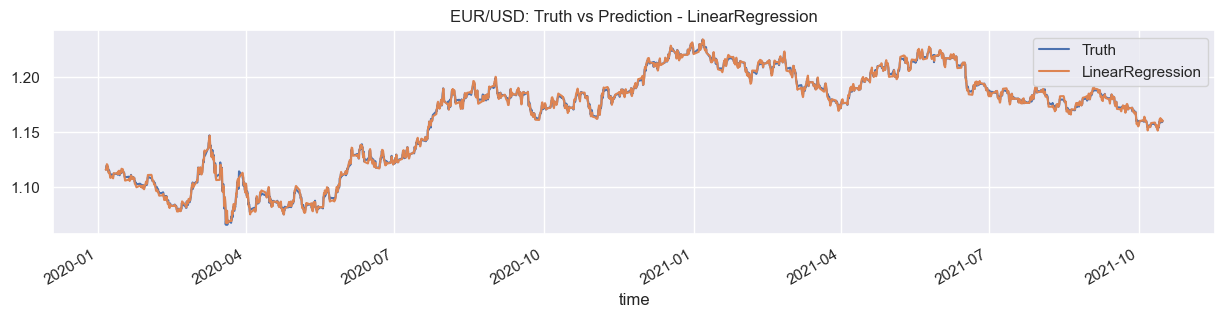

In [37]:
model_name = 'LinearRegression'
plot_true_pred(y_pred_lr_test, model_name)

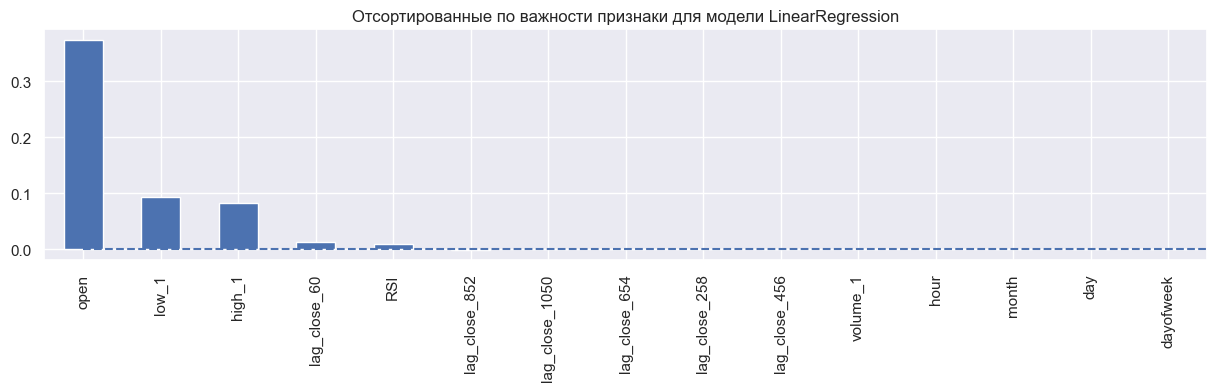

In [38]:
plot_coefficients(lr.coef_, model_name)

### SGDRegressor

In [39]:
#создадим функцию для расчета метрики RMSE
def rmse_score(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

scorer = make_scorer(rmse_score, greater_is_better=False)

In [40]:
sgd = SGDRegressor()

sgd_parameters = {
    'penalty':['l1', 'l2', 'elasticnet'],
    'alpha': [1e-5, 3e-5, 1e-4],
    'eta0': [0.01, 0.03, 0.1],
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    sgd,
    sgd_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scorer
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SGDRegressor(), n_jobs=-1,
             param_grid={'alpha': [1e-05, 3e-05, 0.0001],
                         'eta0': [0.01, 0.03, 0.1],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [41]:
print('Лучшие гиперпараметры модели SGDRegressor:', grid_search.best_params_)

sgd_best_model = grid_search.best_estimator_
rmse_train_sgd = abs(grid_search.best_score_.round(5))

y_pred_sgd_test = sgd_best_model.predict(X_test)
rmse_test_sgd = root_mean_squared_error(y_test, y_pred_sgd_test)

print('RMSE train SGDRegressor при кросс-валидации: {0:.5f}'.format(rmse_train_sgd))
print('RMSE test SGDRegressor: {0:.5f}'.format(rmse_test_sgd))

Лучшие гиперпараметры модели SGDRegressor: {'alpha': 0.0001, 'eta0': 0.1, 'penalty': 'l1'}
RMSE train SGDRegressor при кросс-валидации: 0.00624
RMSE test SGDRegressor: 0.00202


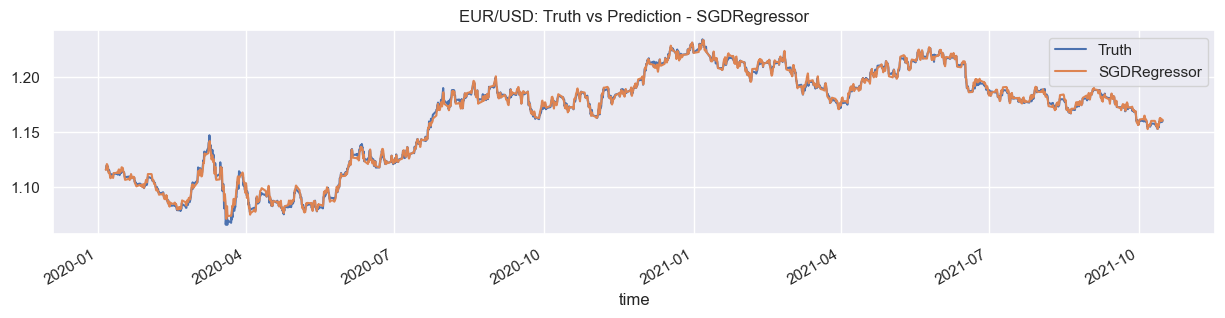

In [42]:
model_name = 'SGDRegressor'
plot_true_pred(y_pred_sgd_test, model_name)

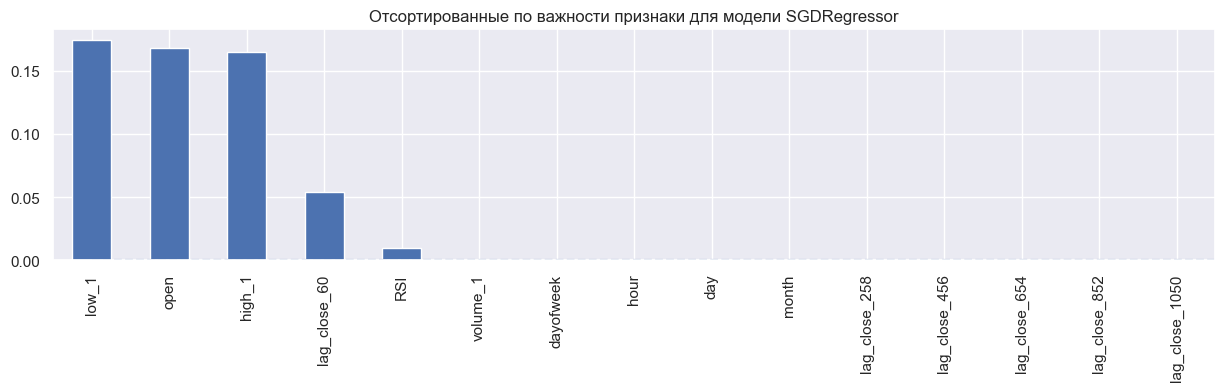

In [43]:
plot_coefficients(sgd_best_model.coef_, model_name)

### CatBoostRegressor

In [44]:
cbr = CatBoostRegressor(random_state=RANDOM_STATE, iterations=50, verbose=False)

cbr_parameters = {
    'simple_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
    'combinations_ctr': ['Buckets', 'BinarizedTargetMeanValue', 'Counter'],
    'max_depth': range(3, 7),
}

grid_search = GridSearchCV(
    cbr,
    cbr_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scorer
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x29b335c10>,
             n_jobs=-1,
             param_grid={'combinations_ctr': ['Buckets',
                                              'BinarizedTargetMeanValue',
                                              'Counter'],
                         'max_depth': range(3, 7),
                         'simple_ctr': ['Buckets', 'BinarizedTargetMeanValue',
                                        'Counter']},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [45]:
print('Лучшие гиперпараметры модели CatBoostRegressor:', grid_search.best_params_)

cbr_best_model = grid_search.best_estimator_
rmse_train_cbr = abs(grid_search.best_score_.round(5))

y_pred_cbr_test = cbr_best_model.predict(X_test)
rmse_test_cbr = root_mean_squared_error(y_test, y_pred_cbr_test)

print('RMSE train CatBoostRegressor при кросс-валидации: {0:.5f}'.format(rmse_train_cbr))
print('RMSE test CatBoostRegressor: {0:.5f}'.format(rmse_test_cbr))

Лучшие гиперпараметры модели CatBoostRegressor: {'combinations_ctr': 'Buckets', 'max_depth': 3, 'simple_ctr': 'Buckets'}
RMSE train CatBoostRegressor при кросс-валидации: 0.03742
RMSE test CatBoostRegressor: 0.00380


In [46]:
cbr_pred = cbr_best_model.predict(X_test)
print('RMSE CatBoostRegressor: {0:.5f}'.format(root_mean_squared_error(y_test, cbr_pred)))

RMSE CatBoostRegressor: 0.00380


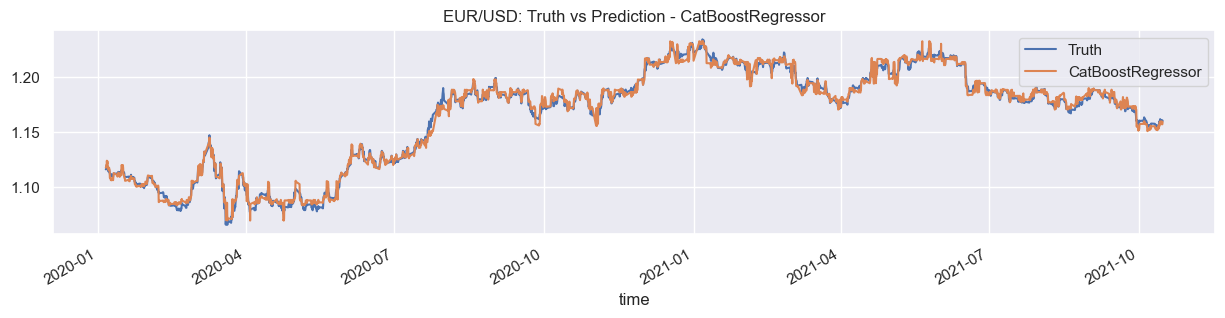

In [47]:
model_name = 'CatBoostRegressor'
plot_true_pred(y_pred_cbr_test, model_name)

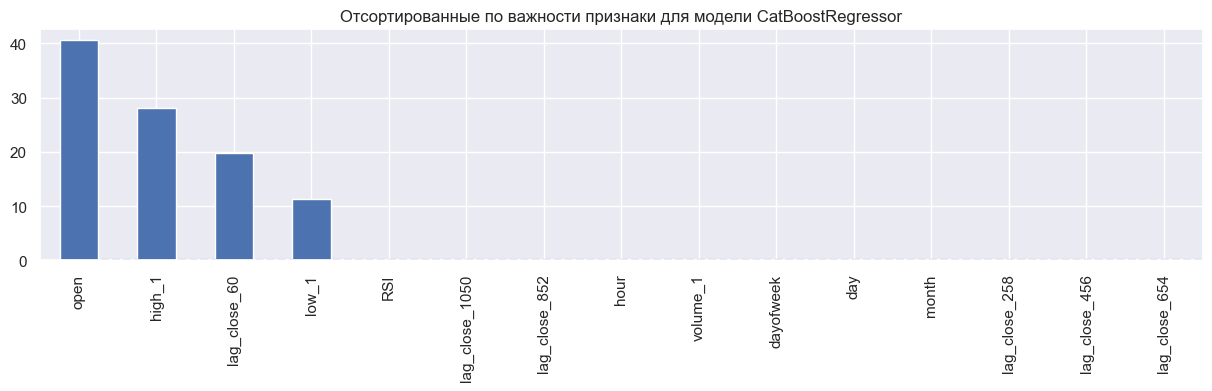

In [48]:
plot_coefficients(cbr_best_model.feature_importances_, model_name)

### LGBMRegressor

In [49]:
lgbm = LGBMRegressor(random_state=RANDOM_STATE, n_estimators=50, verbose=-1)

lgbm_parameters = {
    'num_leaves': range(4, 10),
    'max_depth': range(4, 10)
}

grid_search = GridSearchCV(
    lgbm,
    lgbm_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scorer
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(n_estimators=50, random_state=42,
                                     verbose=-1),
             n_jobs=-1,
             param_grid={'max_depth': range(4, 10), 'num_leaves': range(4, 10)},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [50]:
print('Лучшие гиперпараметры модели LGBMRegressor:', grid_search.best_params_)

lgbm_best_model = grid_search.best_estimator_
rmse_train_lgbm = abs(grid_search.best_score_.round(5))

y_pred_lgbm_test = lgbm_best_model.predict(X_test)
rmse_test_lgbm = root_mean_squared_error(y_test, y_pred_lgbm_test)

print('RMSE train LGBMRegressor при кросс-валидации: {0:.5f}'.format(rmse_train_lgbm))
print('RMSE test LGBMRegressor: {0:.5f}'.format(rmse_test_lgbm))

Лучшие гиперпараметры модели LGBMRegressor: {'max_depth': 5, 'num_leaves': 9}
RMSE train LGBMRegressor при кросс-валидации: 0.03608
RMSE test LGBMRegressor: 0.00221


In [51]:
lgbm_pred = lgbm_best_model.predict(X_test)
print('RMSE LGBMRegressor: {0:.5f}'.format(root_mean_squared_error(y_test, lgbm_pred)))

RMSE LGBMRegressor: 0.00221


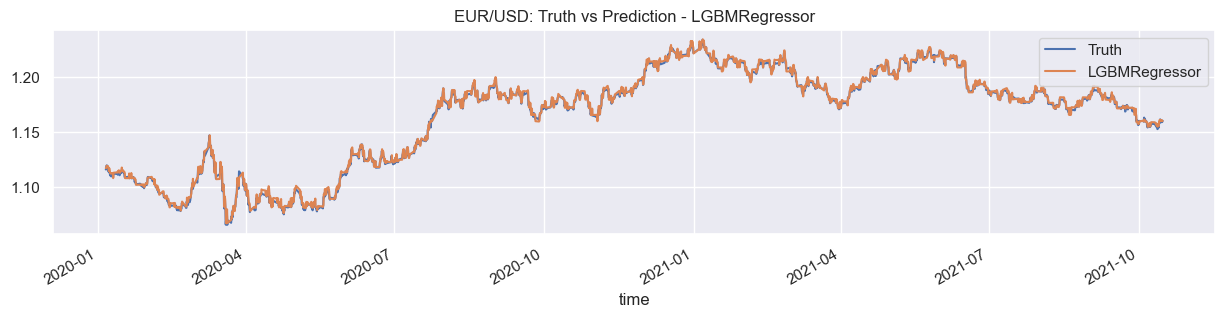

In [52]:
model_name = 'LGBMRegressor'
plot_true_pred(y_pred_lgbm_test, model_name)

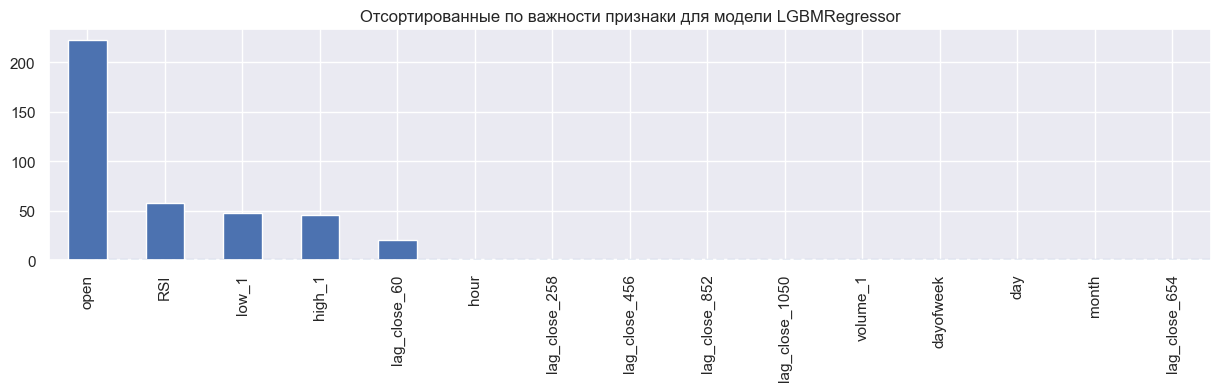

In [53]:
plot_coefficients(lgbm_best_model.feature_importances_, model_name)

### LassoRegression

In [54]:
lasso = Lasso(random_state=RANDOM_STATE)

lasso_parameters = {
    'max_iter': [3000, 5000, 10000],
    'alpha': [0.01, 0.1, 1],
}

grid_search = GridSearchCV(
    lasso,
    lasso_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scorer
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Lasso(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1],
                         'max_iter': [3000, 5000, 10000]},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [55]:
print('Лучшие гиперпараметры модели Lasso:', grid_search.best_params_)

lasso_best_model = grid_search.best_estimator_
rmse_train_lasso = abs(grid_search.best_score_.round(5))

y_pred_lasso_test = lasso_best_model.predict(X_test)
rmse_test_lasso = root_mean_squared_error(y_test, y_pred_lasso_test)

print('RMSE train Lasso при кросс-валидации: {0:.5f}'.format(rmse_train_lasso))
print('RMSE test Lasso: {0:.5f}'.format(rmse_test_lasso))

Лучшие гиперпараметры модели Lasso: {'alpha': 0.01, 'max_iter': 3000}
RMSE train Lasso при кросс-валидации: 0.09217
RMSE test Lasso: 0.04291


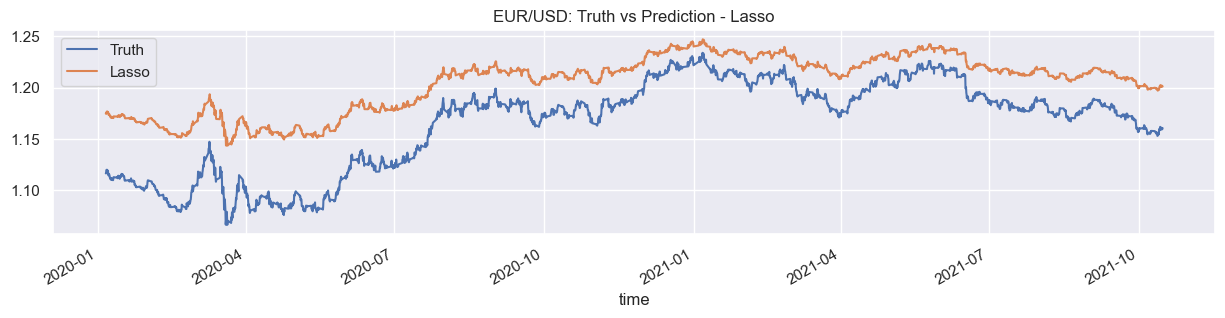

In [56]:
model_name = 'Lasso'
plot_true_pred(y_pred_lasso_test, model_name)

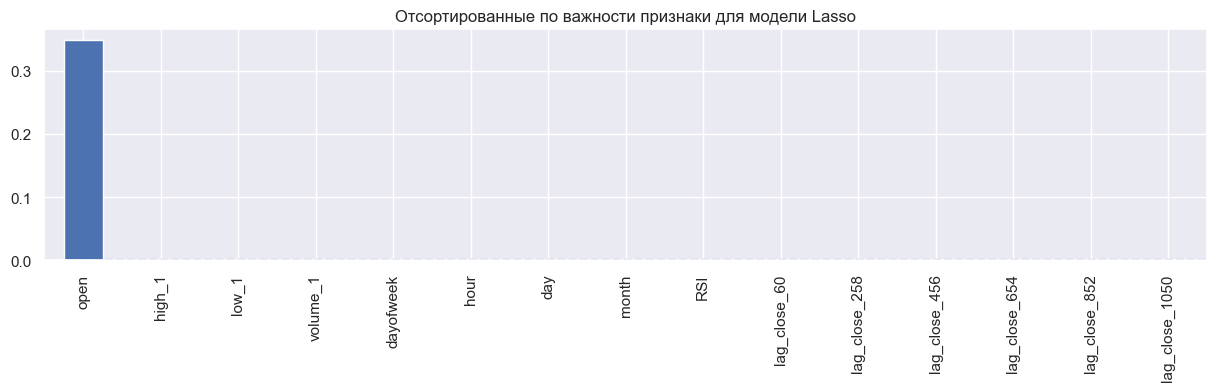

In [57]:
plot_coefficients(lasso_best_model.coef_, model_name)

### RidgeRegression

In [58]:
ridge = Ridge()

ridge_parameters = {
    'alpha': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(
    ridge,
    ridge_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scorer
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10]},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [59]:
print('Лучшие гиперпараметры модели Ridge:', grid_search.best_params_)

ridge_best_model = grid_search.best_estimator_
rmse_train_ridge = abs(grid_search.best_score_.round(5))

y_pred_ridge_test = ridge_best_model.predict(X_test)
rmse_test_ridge = root_mean_squared_error(y_test, y_pred_ridge_test)

print('RMSE train Ridge при кросс-валидации: {0:.5f}'.format(rmse_train_ridge))
print('RMSE test Ridge: {0:.5f}'.format(rmse_test_ridge))

Лучшие гиперпараметры модели Ridge: {'alpha': 0.01}
RMSE train Ridge при кросс-валидации: 0.00262
RMSE test Ridge: 0.00176


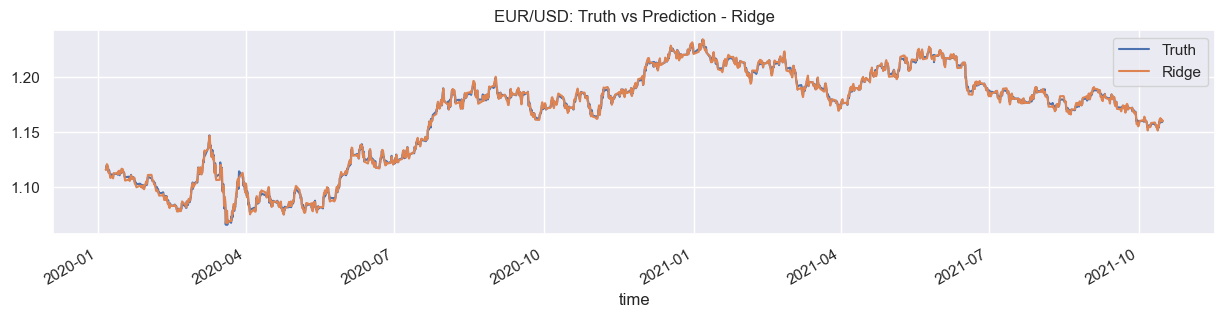

In [60]:
model_name = 'Ridge'
plot_true_pred(y_pred_ridge_test, model_name)

In [61]:
train.head(2)

,open,close,high_1,low_1,volume_1,dayofweek,hour,day,month,RSI,lag_close_60,lag_close_258,lag_close_456,lag_close_654,lag_close_852,lag_close_1050
time,,,,,,,,,,,,,,,,
2004-01-02 18:00:00,1.25998,1.25832,1.26165,1.25624,407725.1016,4,18,2,1,50.254378,1.23739,1.14933,1.12556,1.13570,1.16883,1.12274
2004-01-04 22:00:00,1.25832,1.26569,1.26031,1.25762,285794.4981,6,22,4,1,72.780498,1.23771,1.14741,1.12409,1.13432,1.16818,1.12126


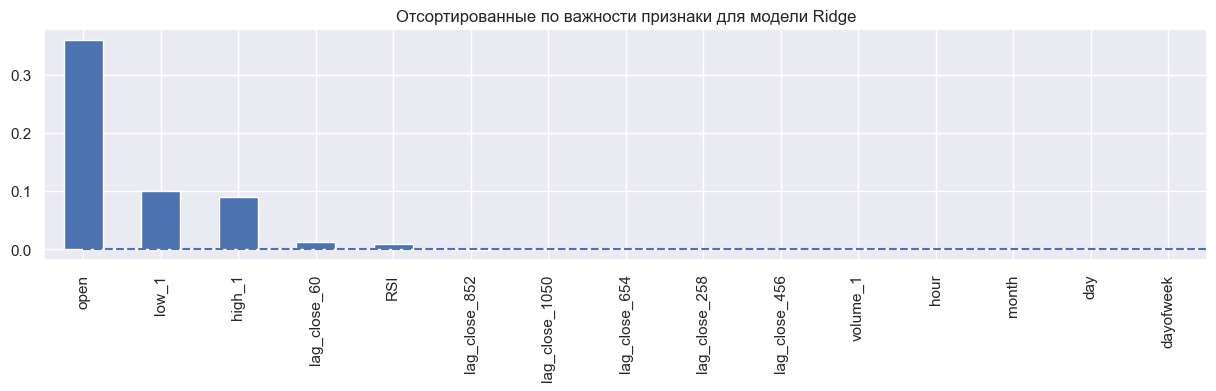

In [62]:
plot_coefficients(ridge_best_model.coef_, model_name)

### DecisionTreeRegressor

In [63]:
dt = DecisionTreeRegressor(random_state=RANDOM_STATE)

dt_parameters = {
    'max_depth': range(1, 10),
    'min_samples_split': range(4, 7),
    'min_samples_leaf': range(4, 7)
}

grid_search = GridSearchCV(
    dt,
    dt_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scorer
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(1, 10),
                         'min_samples_leaf': range(4, 7),
                         'min_samples_split': range(4, 7)},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [64]:
print('Лучшие гиперпараметры модели DecisionTreeRegressor:', grid_search.best_params_)

dt_best_model = grid_search.best_estimator_
rmse_train_dt = abs(grid_search.best_score_.round(5))

y_pred_dt_test = dt_best_model.predict(X_test)
rmse_test_dt = root_mean_squared_error(y_test, y_pred_dt_test)

print('RMSE train DecisionTreeRegressor при кросс-валидации: {0:.5f}'.format(rmse_train_dt))
print('RMSE test DecisionTreeRegressor: {0:.5f}'.format(rmse_test_dt))

Лучшие гиперпараметры модели DecisionTreeRegressor: {'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 4}
RMSE train DecisionTreeRegressor при кросс-валидации: 0.03599
RMSE test DecisionTreeRegressor: 0.00237


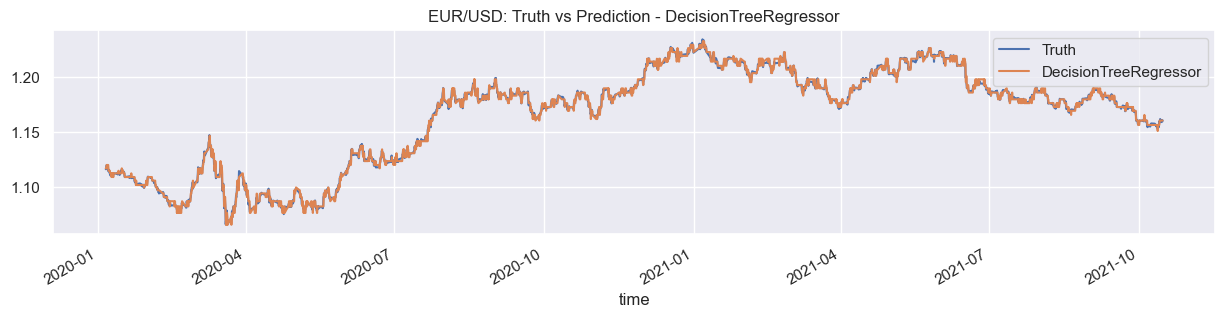

In [65]:
model_name = 'DecisionTreeRegressor'
plot_true_pred(y_pred_dt_test, model_name)

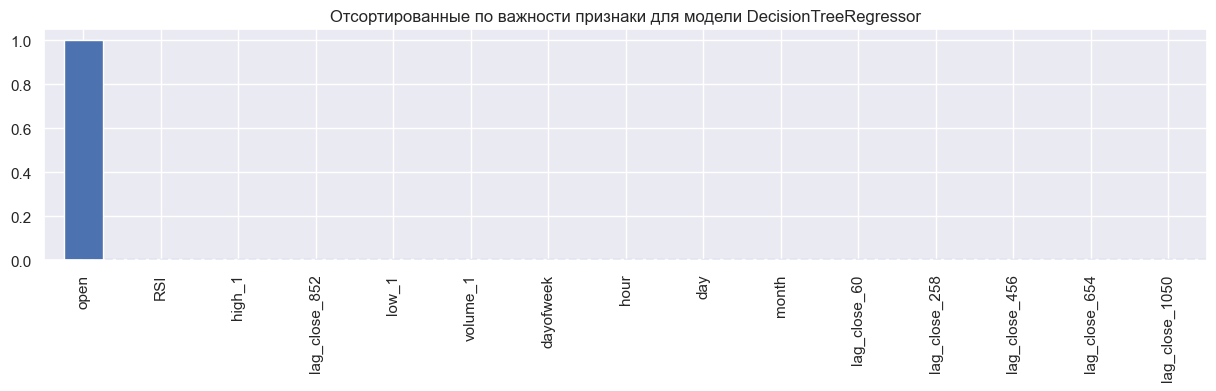

In [66]:
plot_coefficients(dt_best_model.feature_importances_, model_name)

### SVR

In [67]:
svr = SVR(verbose=False, kernel='linear')

svr_parameters = {
    'epsilon': [0.005, 0.01, 0.1, 0.5]
}

grid_search = GridSearchCV(
    svr,
    svr_parameters,
    n_jobs=-1,
    cv=tscv,
    scoring=scorer
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVR(kernel='linear'), n_jobs=-1,
             param_grid={'epsilon': [0.005, 0.01, 0.1, 0.5]},
             scoring=make_scorer(rmse_score, greater_is_better=False, response_method='predict'))

In [68]:
print('Лучшие гиперпараметры модели SVR:', grid_search.best_params_)

svr_best_model = grid_search.best_estimator_
rmse_train_svr = abs(grid_search.best_score_.round(5))

y_pred_svr_test = svr_best_model.predict(X_test)
rmse_test_svr = root_mean_squared_error(y_test, y_pred_svr_test)

print('RMSE train SVR при кросс-валидации: {0:.5f}'.format(rmse_train_svr))
print('RMSE test SVR: {0:.5f}'.format(rmse_test_svr))

Лучшие гиперпараметры модели SVR: {'epsilon': 0.005}
RMSE train SVR при кросс-валидации: 0.00291
RMSE test SVR: 0.00228


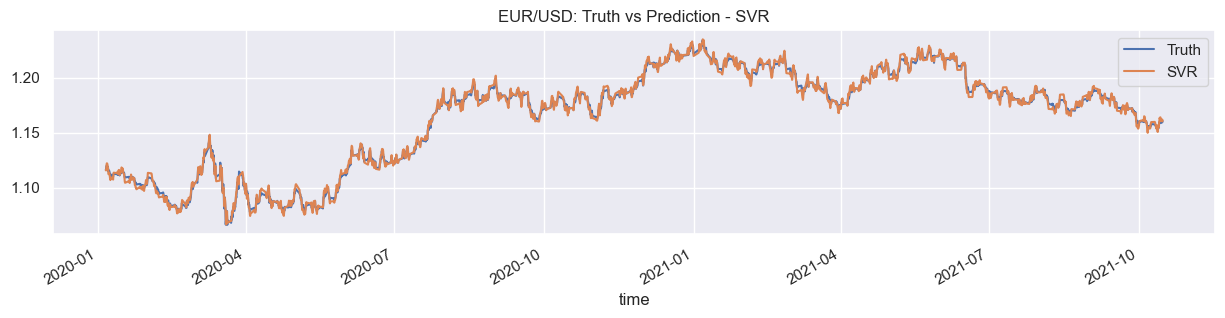

In [69]:
model_name = 'SVR'
plot_true_pred(y_pred_svr_test, model_name)

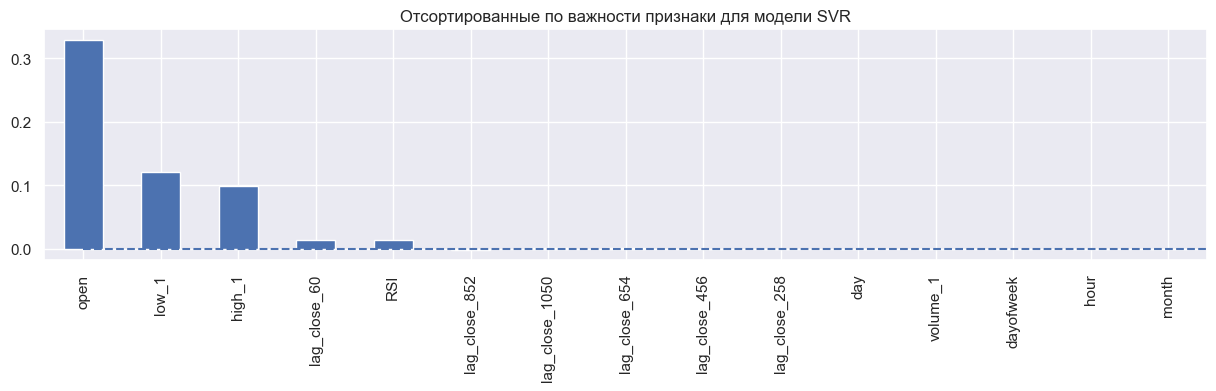

In [70]:
plot_coefficients(svr_best_model.coef_[0], model_name)

Выполним сравнение метрики RMSE.

In [71]:
rmse_train = pd.Series({'LR':rmse_train_lr.round(5),
                         'SGD':rmse_train_sgd.round(5),
                         'CB':rmse_train_cbr.round(5),
                         'LGBM':rmse_train_lgbm.round(5),
                         'Lasso':rmse_train_lasso.round(5),
                         'Ridge':rmse_train_ridge.round(5),
                         'DT':rmse_train_dt.round(5),
                         'SVR':rmse_train_svr.round(5)})

rmse_test = pd.Series({'LR':rmse_test_lr.round(5),
                         'SGD':rmse_test_sgd.round(5),
                         'CB':rmse_test_cbr.round(5),
                         'LGBM':rmse_test_lgbm.round(5),
                         'Lasso':rmse_test_lasso.round(5),
                         'Ridge':rmse_test_ridge.round(5),
                         'DT':rmse_test_dt.round(5),
                         'SVR':rmse_test_svr.round(5)})

In [72]:
rmse_train = pd.DataFrame(rmse_train.items(), columns=['model','RMSE train'])
rmse_test = pd.DataFrame(rmse_test.items(), columns=['model','RMSE test'])

RMSE_result = rmse_train.merge(rmse_test, on='model')
RMSE_result

,model,RMSE train,RMSE test
0,LR,0.00263,0.00176
1,SGD,0.00624,0.00202
2,CB,0.03742,0.00380
3,LGBM,0.03608,0.00221
4,Lasso,0.09217,0.04291
5,Ridge,0.00262,0.00176
6,DT,0.03599,0.00237
7,SVR,0.00291,0.00228


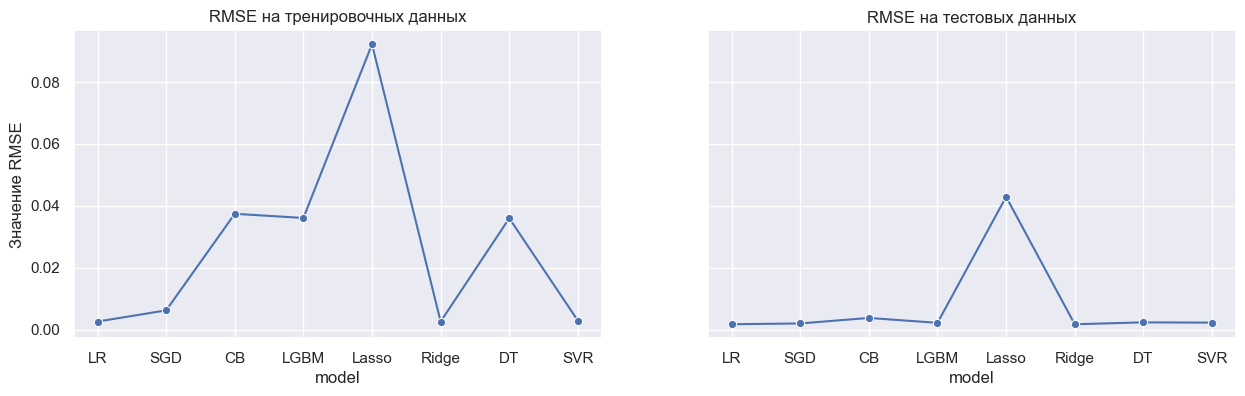

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
sns.lineplot(data=RMSE_result, x='model', y='RMSE train', marker='o', ax=ax[0])
sns.lineplot(data=RMSE_result, x='model', y='RMSE test', marker='o', ax=ax[1])
ax[0].set_title('RMSE на тренировочных данных')
ax[1].set_title('RMSE на тестовых данных')
ax[0].set_ylabel('Значение RMSE')
ax[1].set_ylabel('Значение RMSE')
plt.show()

**Выводы:**
- В набор данных были добавлены новые сгенерированные признаки (RSI, скользящее среднее, предыдущие значения со сдвигом). Тестовая выборка составила 10% от исходных данных. Было выполнено масштабирование признаков с помощью MinMaxScaler.
- С целью предсказания закрытия курса на следующий 4-часовой интервал  были обучены модели LinearRegression, SGDRegressor, CatBoostRegressor, LGBMRegressor, Lasso, Ridge, DecisionTreeRegressor, SVR. Был осуществлен подбор гиперпараметров с помощью GridSearchCV. Были приведены отсортированные по важности признаки для каждой модели.
  - LinearRegression: RMSE train = 0.00263. Наиболее важные признаки: `open`, `low_1`, `high_1`, `lag_close_60`, `RSI`.
  - SGDRegressor: RMSE train = 0.00640. Наиболее важные признаки: `low_1`, `open`, `high_1`, `lag_close_60`, `RSI`.
  - CatBoostRegressor: RMSE train = 0.03742. Наиболее важные признаки: `open`, `high_1`, `lag_close_60`, `low_1`.
  - LGBMRegressor: RMSE train = 0.03608. Наиболее важные признаки: `open`, `RSI`, `low_1`, `high_1`, `lag_close_60`.
  - Lasso: RMSE train = 0.09217. Наиболее важные признаки: `open`.
  - Ridge: RMSE train = 0.00291. Наиболее важные признаки: `open`, `low_1`, `high_1`, `lag_close_60`, `RSI`.
  - DecisionTreeRegressor: RMSE train = 0.03599. Наиболее важные признаки: `open`.
  - SVR: RMSE train = 0.00291. Наиболее важные признаки: `open`, `low_1`, `high_1`, `lag_close_60`, `RSI`.
- Была выбрана лучшая модель на основе метрики RMSE - Linear Regression, для которой метрика RMSE test составила 0.00176 и подтвердила качество модели.

## Выводы

- Была выполнена загрузка данных курса EUR/USD. В данных содержится 28860 записей о курсе за каждый 4-часовой интервал за период с 2003-05-04 21:00:00 по 2021-10-15 17:00:00. Пропуски в данных отсутствуют.
- Были построены графики зависимости курса от времени и показателя `RSI`, а также боксплоты для значений `open`, `high`, `low`, `close`, `volume`. Средние значения показателей `open`, `high`, `low`, `close` составляют около 1.25, минимумы - около 1.04, максимумы - около 1.60. Среднее значение показателя `volume` составляет 83078.84, минимум - 0, максимум - 752269.09. 
- Были построены графики скользящего среднего и стандартного отклонения. Скользящее среднее сгладило исходный временной ряд и помогло выявить закономерности. С помощью функции `seasonal_decomposed` было выполнено разложение временного ряда на 3 составляющие: тренд, сезонность и остаток. Были построены их графики. Сезонность составляет около 9 месяцев, т.е. колебания в данных повторяются с данной периодичностью. Значение сначала довольно резко уменьшается, а затем постепенно набирает рост. После достижения пика на этом периоде следует спад, а далее снова поъем. Циклические изменения курса, которые повторяются с постоянным интервалом времени, составляют около 0.012. В течение рассмотренного периода происходили резкие падения курса, идентифицированные как аномалии.
- Установлено, что временной ряд является нестационарным, меняются его среднее значение и стандартное отклонение. При этом разности временного ряда более стационарны, чем сам ряд.
- В набор данных были добавлены новые сгенерированные признаки (RSI, скользящее среднее, предыдущие значения со сдвигом). Тестовая выборка составила 10% от исходных данных. Было выполнено масштабирование признаков с помощью MinMaxScaler.
- С целью предсказания закрытия курса на следующий 4-часовой интервал  были обучены модели LinearRegression, SGDRegressor, CatBoostRegressor, LGBMRegressor, Lasso, Ridge, DecisionTreeRegressor, SVR. Был осуществлен подбор гиперпараметров с помощью GridSearchCV. Были приведены отсортированные по важности признаки для каждой модели.
  - LinearRegression: RMSE train = 0.00263. Наиболее важные признаки: `open`, `low_1`, `high_1`, `lag_close_60`, `RSI`.
  - SGDRegressor: RMSE train = 0.00640. Наиболее важные признаки: `low_1`, `open`, `high_1`, `lag_close_60`, `RSI`.
  - CatBoostRegressor: RMSE train = 0.03742. Наиболее важные признаки: `open`, `high_1`, `lag_close_60`, `low_1`.
  - LGBMRegressor: RMSE train = 0.03608. Наиболее важные признаки: `open`, `RSI`, `low_1`, `high_1`, `lag_close_60`.
  - Lasso: RMSE train = 0.09217. Наиболее важные признаки: `open`.
  - Ridge: RMSE train = 0.00291. Наиболее важные признаки: `open`, `low_1`, `high_1`, `lag_close_60`, `RSI`.
  - DecisionTreeRegressor: RMSE train = 0.03599. Наиболее важные признаки: `open`.
  - SVR: RMSE train = 0.00291. Наиболее важные признаки: `open`, `low_1`, `high_1`, `lag_close_60`, `RSI`.
- Была выбрана лучшая модель на основе метрики RMSE - Linear Regression, для которой метрика RMSE test составила 0.00176 и подтвердила качество модели.